In [1]:
import os
import sys

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import librosa
import random
import IPython.display as ipd

In [2]:
INPUT_DIR = r'C:\Users\HP VICTUS\Desktop\coding goes skrrr\ntu_godlikegospel\python\DSAI proj\input'

# use only set_b
meta = pd.read_csv(f'{INPUT_DIR}/set_b.csv')

In [3]:
meta.head()

,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN


In [4]:
meta.label.value_counts()

normal        320
murmur         95
extrastole     46
Name: label, dtype: int64

- match **meta.fname** with **input/set_b/**

In [5]:
# mapping function
def mod_fname(fname):
    liststr = fname[6:].split('_')
    
    if liststr[0] == 'Bunlabelledtest':
        liststr[0] += '_'
    else: # Bunlabelled
        if len(liststr) == 5: # not noisy
            liststr.pop(0)
            liststr[0] += '_'
        else: # noisy
            liststr.pop(0)
            liststr.pop(1)

    return '_'.join(liststr)


# map to meta 
meta.fname = meta.fname.map(mod_fname)
meta.fname

0            extrastole__127_1306764300147_C2.wav
1             extrastole__128_1306344005749_A.wav
2             extrastole__130_1306347376079_D.wav
3            extrastole__134_1306428161797_C1.wav
4             extrastole__138_1306762146980_B.wav
                          ...                    
651    normal_noisynormal_284_1311168471850_A.wav
652    normal_noisynormal_284_1311168471850_B.wav
653    normal_noisynormal_285_1311169246969_C.wav
654    normal_noisynormal_296_1311682952647_C.wav
655    normal_noisynormal_296_1311682952647_D.wav
Name: fname, Length: 656, dtype: object

- separate **labeled** and **unlabeled** datasets

In [6]:
labeled = meta.loc[meta.label.notna()].reset_index(drop=True)
unlabeled = meta.loc[meta.label.isna()].reset_index(drop=True)

len(labeled), len(unlabeled)

(461, 195)

## Basic Visualization
---
- display audio object
- plotted **waveform** of the signal
- **spectrum**
- **spectrogram**

In [7]:
# load audio from filepath
def get_audio(filepath):
    sound, sample_rate = librosa.load(filepath)
    return ipd.Audio(sound, rate = sample_rate), sound, sample_rate

# display raw signals
# X-axis: time
# Y-axis: amplitude
def show_waveform(sound, sample_rate):
    plt.figure(figsize = (20, 5))
    librosa.display.waveshow(sound, sr=sample_rate)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Signal Waveform')
    plt.show()

# display sound spectrum
# DFT using FFT
def show_spectrum(sound, sample_rate):
    fft = np.fft.fft(sound)
    amp = np.abs(fft) # amplitude of fourier
    t = np.linspace(0, sample_rate, len(amp))

    plt.figure(figsize = (9, 6))
    plt.plot(t[:len(t)//2], amp[:len(t)//2]) # remove complex conjugate from fft
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.title('Spectrum')
    plt.show()

# display linear frequency power spectogram
# STFT
def show_spectrogram(sound, sample_rate, hop_length):
    stft = librosa.stft(sound, hop_length=hop_length)
    spec = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    plt.figure(figsize=(12, 8))
    librosa.display.specshow(spec, sr = sample_rate, x_axis = 'time', y_axis = 'linear', hop_length=hop_length)
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.colorbar(format = '%2.0f dB')
    plt.title('Spectrogram')
    plt.show()

# mel-scale spectrogram
def show_mel_spectrogram(sound, sample_rate, hop_length):
    mel_spec = librosa.feature.melspectrogram(y = sound, sr = sample_rate, hop_length=hop_length)
    
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(mel_spec, sr = sample_rate, x_axis = 'time', y_axis='mel', hop_length=hop_length)
    plt.colorbar(format = '%2.0f')
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.title('Mel Spectrogram')
    plt.show()

    return mel_spec    

# log mel spectrogram
def show_log_mel_spectrogram(mel_spec, sample_rate, hop_length):
    log_mel_spec = librosa.power_to_db(mel_spec, ref = np.max)

    plt.figure(figsize=(12, 8))
    librosa.display.specshow(log_mel_spec, sr = sample_rate, x_axis = 'time', y_axis='mel', hop_length=hop_length)
    plt.colorbar(format = '%2.0f dB')
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.title('Log Mel Spectrogram')
    plt.show()


In [8]:
sound_data = labeled.iloc[random.randint(0, len(labeled) - 1)]
sound_disp, sound, sample_rate = get_audio(INPUT_DIR + '/set_b/' + sound_data.fname)

In [9]:
print("filename:", sound_data.fname)
print("label\t:", sound_data.label)
print("sublabel:", sound_data.sublabel)
sound_disp

filename: murmur__197_1308141235553_D.wav
label	: murmur
sublabel: nan


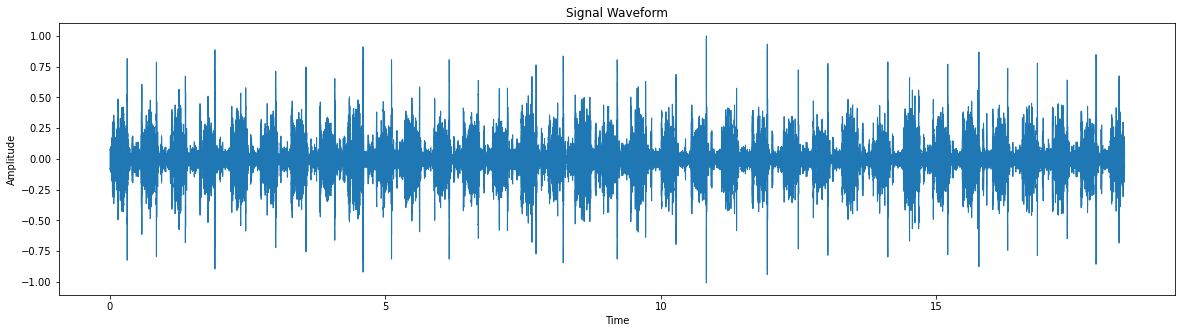

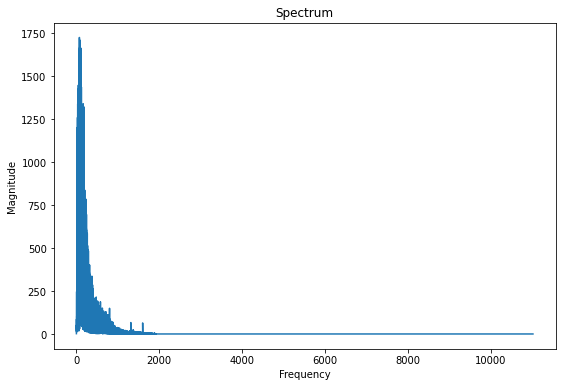

In [10]:
show_waveform(sound, sample_rate)
show_spectrum(sound, sample_rate)

---
- visualise linear freq power spectrogram

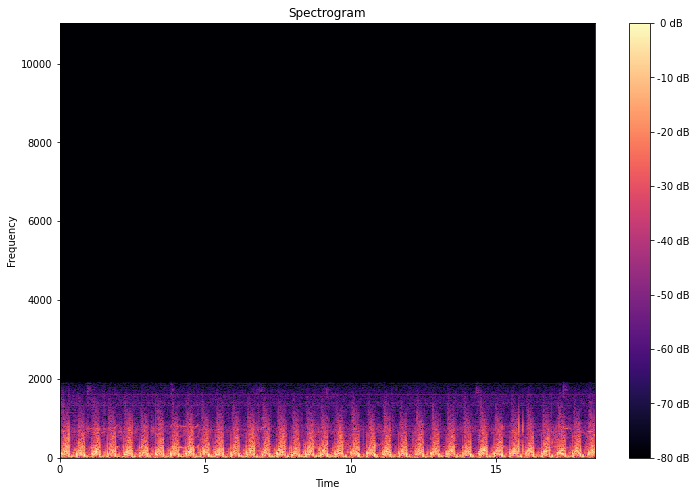

In [11]:
show_spectrogram(sound, sample_rate, hop_length = 512)

---
- rescale frequency to mel scale

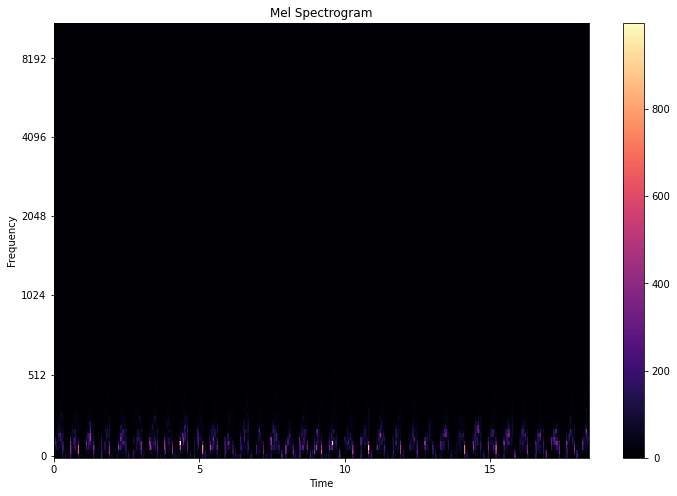

In [12]:
mel_spec = show_mel_spectrogram(sound, sample_rate, hop_length = 512)

- rescale to mel log scale

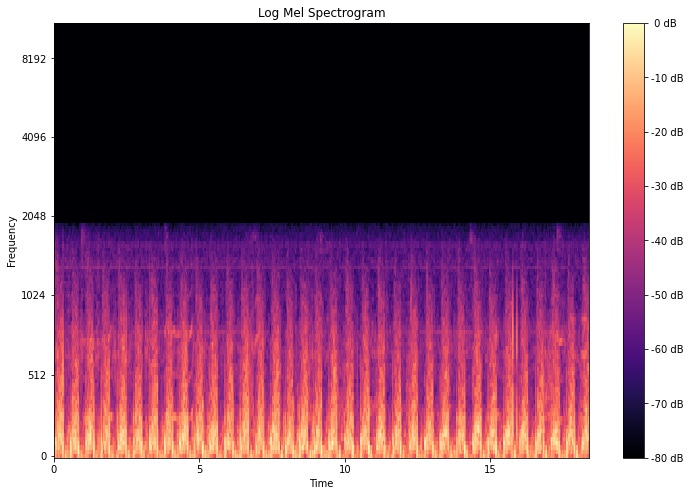

In [13]:
show_log_mel_spectrogram(mel_spec, sample_rate, hop_length = 512)

## Data Preprocessing
---
- Augmentation of sound data
    - *stretch*
    - *shift*
    - *add noise*
- Feature extraction
    - *Mel-Frequency Cepstral Coefficients* | **MFCC**